In [1]:
!pip install -q tslearn umap-learn scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, silhouette_score
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tslearn.datasets import UCR_UEA_datasets

In [3]:
# Configurações
sns.set(style="whitegrid")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
# 1. Carregamento do ECG5000
ucr = UCR_UEA_datasets()
X, y, _, _ = ucr.load_dataset("ECG5000")

In [5]:
# Normalização
X = X.reshape((X.shape[0], X.shape[1]))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [6]:
# Split: treino supervisionado (10%), teste (90%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.9, stratify=y, random_state=42)


In [7]:
# 2. Dataset PyTorch
class ECGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32).unsqueeze(1)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx], self.labels[idx]

train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

In [8]:
# 3. Modelo supervisionado CNN + Linear
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2), nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, padding=2), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.classifier = nn.Linear(64, 5)  # 5 classes no ECG5000

    def forward(self, x):
        z = self.encoder(x).squeeze(-1)
        return self.classifier(z)


In [9]:
# 4. Treinamento supervisionado completo
model = CNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

for epoch in range(100):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")


Epoch 1 - Loss: 1.6210
Epoch 2 - Loss: 1.5750
Epoch 3 - Loss: 1.5322
Epoch 4 - Loss: 1.4916
Epoch 5 - Loss: 1.4529
Epoch 6 - Loss: 1.4157
Epoch 7 - Loss: 1.3803
Epoch 8 - Loss: 1.3461
Epoch 9 - Loss: 1.3126
Epoch 10 - Loss: 1.2796
Epoch 11 - Loss: 1.2473
Epoch 12 - Loss: 1.2163
Epoch 13 - Loss: 1.1866
Epoch 14 - Loss: 1.1584
Epoch 15 - Loss: 1.1320
Epoch 16 - Loss: 1.1075
Epoch 17 - Loss: 1.0852
Epoch 18 - Loss: 1.0649
Epoch 19 - Loss: 1.0469
Epoch 20 - Loss: 1.0312
Epoch 21 - Loss: 1.0177
Epoch 22 - Loss: 1.0061
Epoch 23 - Loss: 0.9961
Epoch 24 - Loss: 0.9871
Epoch 25 - Loss: 0.9788
Epoch 26 - Loss: 0.9712
Epoch 27 - Loss: 0.9639
Epoch 28 - Loss: 0.9569
Epoch 29 - Loss: 0.9499
Epoch 30 - Loss: 0.9430
Epoch 31 - Loss: 0.9362
Epoch 32 - Loss: 0.9293
Epoch 33 - Loss: 0.9224
Epoch 34 - Loss: 0.9154
Epoch 35 - Loss: 0.9082
Epoch 36 - Loss: 0.9008
Epoch 37 - Loss: 0.8934
Epoch 38 - Loss: 0.8860
Epoch 39 - Loss: 0.8787
Epoch 40 - Loss: 0.8717
Epoch 41 - Loss: 0.8648
Epoch 42 - Loss: 0.8579
E

In [10]:
# 5. Extração dos embeddings supervisionados
def extract_embeddings(model, dataset):
    loader = DataLoader(dataset, batch_size=64)
    model.eval()
    emb, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            z = model.encoder(x).squeeze(-1)
            emb.append(z.cpu().numpy())
            labels.append(y.numpy())
    return np.concatenate(emb), np.concatenate(labels)

emb_test, y_true = extract_embeddings(model, test_dataset)


In [11]:
# 6. Classificação com Linear Probe externa (opcional)
clf = LogisticRegression(max_iter=1000).fit(emb_test, y_true)
y_pred = clf.predict(emb_test)

In [12]:
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="macro")
sil = silhouette_score(emb_test, y_true)

print(f"\n=== Avaliação Supervisionada ===")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score (macro): {f1:.4f}")
print(f"Silhouette Score: {sil:.4f}")


=== Avaliação Supervisionada ===
Accuracy: 0.8467
F1 Score (macro): 0.3878
Silhouette Score: 0.1504


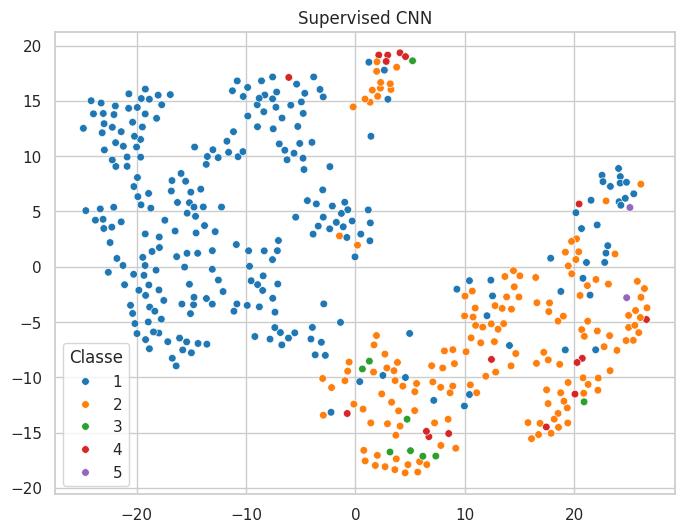

In [13]:
# 8. Visualização com t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_proj = tsne.fit_transform(emb_test)

plt.figure(figsize=(8,6))
sns.scatterplot(x=tsne_proj[:,0], y=tsne_proj[:,1], hue=y_true, palette="tab10", s=30)
plt.title("Supervised CNN")
plt.legend(title="Classe")
plt.show()